<a href="https://colab.research.google.com/github/Adrok24/Proyecto-Integrador/blob/branch_1/TVAE_Test_and_visualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-datasets==1.2.0

     |████████████████████████████████| 2.3MB 6.6MB/s 
  Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1


In [2]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer, Dense, LSTM, Bidirectional, TimeDistributed
import tensorflow.keras.backend as K
import pandas as pd
from random import randint
import pickle

tf.random.set_seed(1234)
pd.options.display.max_colwidth = 100

In [4]:
## Vamos a bajarnos el dataset de dialogos de peliculas de Cornell University
# folder = '/content/drive/My Drive/My Drive/Colab Notebooks/desafio final/'
folder = '/content/drive/My Drive/Colab Notebooks/desafio final/'

path_to_corpus = os.path.join(folder, 'train_corpus_v3.csv')
path_to_corpus

'/content/drive/My Drive/Colab Notebooks/desafio final/train_corpus_v3.csv'

In [5]:
data = pd.read_csv(path_to_corpus, index_col=0)

In [6]:
data.sample(10)

line  ...  Sentimiento
95577   y querías que yo volviera para mantenerlo  ,  porque estás dispuesto a perdonarme lo que llamas ...  ...          NEG
312674                                                                  jamás dejaría que sam se la quedara  ...          NEG
44627                                  o me dejas sola hoy mismo  ,  ahora mismo  ,  o yo me voy de venecia  ...          NEG
276244     desde la cama  ,  @name podía ver la luna en lo alto del cielo enmarcada por la diminuta ventana  ...          NEU
333084                                                                   deseaba que se quedara un poco más  ...          NEG
64581                          @name jefe  ,  changchub gyaltsen  ,  recibe apoyo de la corte chino mongola  ...          NEG
53757   y cuando ambos de ese modo se hubieron serenado y reanimado en silencio  ,  diéronse las manos e...  ...          NEU
306557                                                ¡ todo lo que han dicho esos individuos es mentira  !  ...          NEG
211756                              comentó una de las nuevas secretarias cuando @name cumplió treinta años  ...          NEU
63378                            los filósofos mimamsa no creen en la contemplación en busca de lo absoluto  ...          NEG

[10 rows x 6 columns]

In [7]:
data.shape

(316618, 6)

In [8]:
## tokenizador de subwords
path_to_tokenizer = os.path.join(folder, 'tokenizer.pkl')
with open(path_to_tokenizer, 'rb') as tk_pkl:
        tokenizer = pickle.load(tk_pkl)

### Preprocesamiento

In [9]:
# Usamos train_test_split() para filtrar el volumen de lineas que le vamos a pasar al entrenamiento
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[['line', 'len', 'book', 'Sentimiento']], data['genre'], test_size=0.03, random_state=42, stratify=data['genre'])
print('X_train: ',X_train.shape, 'X_test: ',X_test.shape, 'y_train: ',y_train.shape, 'y_test: ',y_test.shape)

X_train:  (307119, 4) X_test:  (9499, 4) y_train:  (307119,) y_test:  (9499,)


In [10]:
data_train = pd.concat([X_train, y_train],axis=1)
data_test = pd.concat([X_test, y_test],axis=1)

In [11]:
VOCAB_SIZE = tokenizer.vocab_size
MAX_LENGTH = 32

In [12]:
# Funcion para utilizar luego en la reconstrucción
def tokenize_and_filter(inputs):
  tokenized_inputs = []
  
  for sentence1 in inputs:
    # tokenizamos + tokens especiales
    sentence1 = tokenizer.encode(sentence1)
    # filtramos
    if len(sentence1) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
  
  # paddeamos
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs

In [13]:
# Tokenizamos, filtramos las secuencias menores al largo maximo
# y las paddeamos 
def tokenize_and_filter_df(inputs):
  tokenized_inputs = {}
  count_dict = 0
  for index, line in inputs.iterrows():
    sentence = line['line']
    # tokenizamos + tokens especiales
    sentence = tokenizer.encode(sentence)
    # filtramos
    if len(sentence) <= MAX_LENGTH:
      # tokenized_inputs.append(sentence)
      tokenized_inputs[count_dict] = {"line": line['line'], 'secuence': sentence, "len": len(sentence), "genre": line['genre'], "sent": line['Sentimiento']}
      count_dict += 1

  data_filtered = pd.DataFrame.from_dict(tokenized_inputs, "index")
  
  return data_filtered

data_tokens = tokenize_and_filter_df(data_train)
data_tokens_test = tokenize_and_filter_df(data_test)

In [14]:
display(data_tokens.sample(3))
display(data_tokens_test.sample(3))

line  ... sent
253487                               la gente continúa trabajando  ,  pues el trabajo es un entretenimiento  ...  NEU
245411                                                            @name se le quedó mirando  ,  inquisitiva  ...  NEG
250799  @name madre me ha ayudado en los estudios  ,  en todo habéis hecho muchas cosas por mí y no sé c...  ...  POS

[3 rows x 5 columns]

line  ... sent
7976                                                   se lo juro  .   .   .   ,  si las joyas son buenas  ...  NEU
2875  pero inesperadamente tom había sacado una pistola del bolsillo y apuntado al propietario del equipo  ...  NEG
196                                                           pero la voz del pasado era demasiado fuerte  ...  NEG

[3 rows x 5 columns]

In [15]:
# paddeamos
data_lines = tf.keras.preprocessing.sequence.pad_sequences(
    data_tokens.secuence.tolist(), maxlen=MAX_LENGTH, padding='post')

data_lines_test = tf.keras.preprocessing.sequence.pad_sequences(
    data_tokens_test.secuence.tolist(), maxlen=MAX_LENGTH, padding='post')


data_tokens['secuence'] = data_lines.tolist()
data_tokens_test['secuence'] = data_lines_test.tolist()

display(data_tokens.sample(3))
display(data_tokens_test.sample(3))

line  ... sent
193453  kate estaba muy emocionada  ,  se le antojaba un gran reto laboral  ,  y quería estar a su lado  ...  NEU
231148           hacía dos meses que deseaba hacerle una pregunta y hasta entonces no se había atrevido  ...  NEG
191846                                    porque en la otra comarca sí hay facilidades para el embarque  ...  NEU

[3 rows x 5 columns]

line  ... sent
3069                                                      y ya han transcurrido casi ocho y medio  ...  NEU
1050                                 @name titubeó unos instantes y luego se le acercó lentamente  ...  NEU
3359  tenía una carrera  ,  un hogar  ,  una hija siempre había vivido su vida como había querido  ...  POS

[3 rows x 5 columns]

In [16]:
print('Tamaño vocabulario: {}'.format(VOCAB_SIZE))
print('frases: {}'.format(len(data_lines)))

Tamaño vocabulario: 8189
frases: 302936


### Elementos básicos

In [17]:
def scaled_dot_product_attention(query, key, value, mask):
  """Calculamos attention weights """

  ## hacemos el producto de query por la transpuesta de key
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  ## escalamos por la raiz cuadrado del # dims
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  ## agregamos la mascara
  if mask is not None:
    logits += (mask * -1e9)

  ## aplicamos la softmax
  attention_weights = tf.nn.softmax(logits, axis=-1)

  ## y multiplicamos por value 
  output = tf.matmul(attention_weights, value)

  return output

In [18]:
class MultiHeadAttention(tf.keras.layers.Layer):

  ''' Vamos a armar la capa para multihead attention '''

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)

    ## que es este super?
    ## super() te permite acceeder a los metodos de la super clase de la cual
    ## la subclase está heredando. En este caso, estas herendando de Layers.
        
    ## definimos algunos parametros: cuantas cabezas va a tener self attention 
    ## y la dimensionalidad del embedding
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    ## cuantas dimensiones va a tener cada cabeza:
    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    ## vamos a armar la division en cabezas. 
    ## se va a entender mejor en el siguiente bloque de codigo
    ## por ahora es solamente la forma en la que 
    ## reacomodamos los datos para armar las cabezas
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])


  def get_config(self):
          config = super().get_config().copy()
          config.update({
              'num_heads': self.num_heads,
              'd_model': self.d_model,
              'depth': self.depth,
              'query_dense': self.query_dense,
              'key_dense': self.key_dense,
              'value_dense': self.value_dense,
              'dense': self.dense             
          })
          return config

  def call(self, inputs):
    ''' Este call es el metodo que  va a llamar keras para usar la capa'''

    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # print(self.name, mask)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    # acomodamos las dimensiones
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenamos las cabezas
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

In [19]:
## creamos una mascara para el padding (asi nos nos molesta)
## con esto lo que hacemos es despues pasarselo a la capa 
## anterior y eliminamos los paddings

def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)

  return mask[:, tf.newaxis, tf.newaxis, :]

In [20]:
## vamos a crear la otra mascara:
## ahora queremos la mascara para no ver el futuro
## vamos a incorporarle tambien la mascara para el padding

def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)

  ## aca la mascara para el padding
  padding_mask = create_padding_mask(x)

  return tf.maximum(look_ahead_mask, padding_mask)

In [21]:
class PositionalEncoding(tf.keras.layers.Layer):
  ''' Armamos los encodings de posición '''

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  ## comparar con formula de la teorica
  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

   
  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # seno a los indices pares
    sines = tf.math.sin(angle_rads[:, 0::2])
    # coseno a los impares
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, :]
    return tf.cast(pos_encoding, tf.float32)

  def get_config(self):

          config = super().get_config().copy()
          config.update({
              'pos_encoding': self.pos_encoding
          })
          return config

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# Modelo VAE

In [22]:
class Sampling(Layer):
    def call(self, inputs):
        mu, log_var = inputs
        epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
        return mu + K.exp(log_var / 2) * epsilon

In [23]:
## ya tenemos todos los ingredientes para armar una capa de encoder
## todavía no es el encoder entero!

def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [24]:
## ahora si: el encoder
## vamos a definir una funcion que nos devuelva un modelo que tenga
## num_layers bloques de encoder:

def encoder(vocab_size, num_layers, units, d_model, num_heads,
            dropout, latent_space, name="encoder"):
  
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  print('enc_inputs',inputs)

  padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  ## partimos de los embeddings
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  ## y les sumamos el positional encoding
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  ## y usamos tantos bloques como querramos
  for i in range(num_layers):
    outputs = encoder_layer(
                            units=units,
                            d_model=d_model,
                            num_heads=num_heads,
                            dropout=dropout,
                            name="encoder_layer_{}".format(i),
                        )([outputs, padding_mask])

  outputs  = tf.keras.layers.Reshape([MAX_LENGTH * d_model])(outputs)
  # Generamos la media
  
  outputs = tf.keras.layers.Dense(MAX_LENGTH * 10)(outputs)

  outputs = tf.keras.layers.Dense(latent_space)(outputs)
  

  mu = Dense(latent_space, name='mu')(outputs) #TODO: revisar la dimensionalidad del espacio latente


  # Generamos el logaritmo de la varianza
  logvar = Dense(latent_space, name='logvar')(outputs)
  # Usamos esos parámetros para samplear el espacio latente
  z = Sampling(name='encoder_output')([mu, logvar])

  #output = Dense(d_model, name='latent space')(outputs)

  return tf.keras.Model(
      inputs=inputs, outputs=[mu, logvar, z], name=name)

In [25]:
## vamos a usar las mismas partes que ya tenemos para armar el decoder
## primero la decoder layer

def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  
  decoder_input = tf.keras.Input(shape=(None, d_model), name="decoder_input_layer")
  
  # look_ahead_mask = tf.keras.Input(
  #     shape=(1, None, None), name="look_ahead_mask")

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': decoder_input,
          'key': decoder_input,
          'value': decoder_input,
          'mask': None #padding_mask
      })

  #Normalization1
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + decoder_input)

  #FeedFoward
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention1)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)

  #Normalization2
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention1)

  return tf.keras.Model(
      inputs=[decoder_input],
      outputs=outputs,
      name=name)

In [26]:
## y ahora usamos la decoder layer para el decoder

def decoder(vocab_size, num_layers, units, d_model, num_heads,
            dropout ,latent_space, name='decoder'):

  decoder_input = tf.keras.Input(shape=(latent_space), name='decoder_input')

  output = tf.keras.layers.Dense(MAX_LENGTH * 10)(decoder_input)

  
  output = Dense(MAX_LENGTH * d_model, name='linear_proyection')(output)

  output = tf.keras.layers.Reshape([MAX_LENGTH, d_model])(output)
 # print('linear_proyection', output.shape)

  ## la mascara para no ver el futuro y para el padding
  ## ojo que la toma de afuera (es un input, no la creamos aca)

  # look_ahead_mask = tf.keras.Input(
  #     shape=(1, None, None), name='look_ahead_mask')
  

  outputs = tf.keras.layers.Dropout(rate=dropout)(output)

  ## vamos a tener num_layers bloques de decoders
  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs])

  outputs = tf.keras.layers.TimeDistributed(Dense(256))(outputs)
  outputs = tf.keras.layers.LSTM(units=256, return_sequences=True, name='LSTM')(outputs)
  outputs = tf.keras.layers.TimeDistributed(Dense(256))(outputs)


  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(outputs)

#  print('final', output.shape)

  return tf.keras.Model(
      inputs=[decoder_input],
      outputs=outputs,
      name=name)

In [27]:
from tensorflow.keras.models import Model
from contextlib import suppress


beta = K.variable(value=0.0)
beta._trainable = False

class VAEModel(Model):
    def __init__(self, encoder, decoder, a, b, vocab_size, num_layers, units, d_model, num_heads, dropout, latent_space, mask=None,  **kwargs):
        super(VAEModel, self).__init__(**kwargs)
        self.encoder = encoder(
          vocab_size=vocab_size,
          num_layers=num_layers,
          units=units,
          d_model=d_model,
          num_heads=num_heads,
          dropout=dropout,
          latent_space=latent_space)
        
        self.decoder = decoder(
          vocab_size=vocab_size,
          num_layers=num_layers,
          units=units,
          d_model=d_model,
          num_heads=num_heads,
          dropout=dropout,
          latent_space=latent_space)
        
        self.a = a
        self.b = b

    def loss_function(self, y_true, y_pred):
      print("ytrue:",y_true,"ypred:",y_pred)
      y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH)) #(-1, MAX_LENGTH - 1))
      
      ## calculamos la loss sin reducir
      loss = tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True, reduction='none')(y_true, y_pred)

      ## y reducimos la loss
      return tf.reduce_mean(loss)

    # Definimos el train step para que utilice la función de costo compuesta por el error de reconstrucción y la divergencia KL
    def train_step(self, data):
        data = data[0]

        
        # Iniciamos el cálculo de la loss dentro del contexto que registra las operaciones para poder derivarlas
        with tf.GradientTape() as tape:
            # Usamos el encoder para mapear las oraciones al espacio latente y obtenemos los parámetros de la distribución
            
            
            z_mean, z_log_var, z = self.encoder(data)
            # Reconstruimos la oración a partir de z

            reconstruction = self.decoder(z)

            reconstruction_loss = self.loss_function(data, reconstruction)

            # Escalamos la pérdida con el r_loss_factor
           # reconstruction_loss *= self.r_loss_factor
            # Calculamos la divergencia KL usando la media y la varianza
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_sum(kl_loss, axis = 1)
            kl_loss *= -0.5
            # Combinamos las pérdidas
            factor = self.a * beta + self.b
            total_loss = reconstruction_loss + kl_loss * factor

        # Calculamos los gradientes
        grads = tape.gradient(total_loss, self.trainable_weights)
        
        # Actualizamos los pesos
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # El método train_step debe devolver un diccionario
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
            "kl_weight": factor,
        }

    def reconstruct(self, q_sample, silent_reconstruct=False, silent_orig=True):
      _,_,result = model.encoder(q_sample.reshape(1,MAX_LENGTH,1))
      #decoded from sample
      print('Reconstr: ',self.decode_sample(result, silent_reconstruct))

      # original  
      print('Original: ',tokenizer.decode([i for i in q_sample if i < tokenizer.vocab_size]))
      if (silent_orig == False):
        print(q_sample)

    def decode_sample(self, z_sampled, silent_reconstruct=False):
      result = self.decoder(z_sampled)
      with suppress(Exception):
        prediction = np.argmax(result, axis=2)

        pred = prediction[0]
        pred_to_decode = [i for i in pred if i < tokenizer.vocab_size]
        if (silent_reconstruct == False):
          print(pred_to_decode)
        return tokenizer.decode(pred_to_decode)


    def reconstruct_sentence(self, sentence, silent_reconstruct=False, silent_orig=True):
      sentence = [sentence]
      sentence = tokenize_and_filter(sentence)
      sentence = sentence.reshape(MAX_LENGTH)
      return self.reconstruct(sentence, silent_reconstruct, silent_orig)

    def call(self,inputs):
        mu, logvar, z = self.encoder(inputs)
        print("checkpoint_call")

        return self.decoder(z)

In [28]:
# Hyper-parameters
NUM_LAYERS = 6
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.2
LATENT_SPACE = 32
A = 0.0000001
B = 0.00001

# Instanciamos el modelo
model = VAEModel(encoder, decoder, 
    a=A,
    b=B,
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    latent_space=LATENT_SPACE)

enc_inputs KerasTensor(type_spec=TensorSpec(shape=(None, None), dtype=tf.float32, name='inputs'), name='inputs', description="created by layer 'inputs'")


# Cargamos el modelo

In [29]:
model.load_weights('/content/drive/My Drive/Colab Notebooks/desafio final/weights_corpus_v4.HDF5')

# Generacion de frases de samples aleatorios

In [30]:
def generate_from_normal(n_sentences=3):
  errores = 0
  for i in range(n_sentences):
    z_sampled = tf.random.normal(shape=(1,LATENT_SPACE))
    prediction = model.decode_sample(z_sampled,silent_reconstruct=True)
    print(i, ' gen_norm:', prediction)

In [35]:
generate_from_normal()

0  gen_norm: conseguía mortalmente de lo delante que estaba herido y agner consultaba afionamentes
1  gen_norm: nos hago bienclaro en la cabeza  ,  hincrmgon pero la ley hemos dado
2  gen_norm: en que cada día más dejó la corhel entró tiempo hasta que la conversación un segundos antes de hacer las acompaña los dólares


In [36]:
q_sample = data_lines[5]
model.reconstruct(q_sample)

[28, 3078, 91, 2, 97, 550, 31, 654, 1, 23, 13, 5214, 4297, 7965, 2, 959, 2061, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Reconstr:  me enteré de ese nombre del mejor  ,  es un hermoso mental de choún
Original:  me enteré de ese nombre mucho después  ,  por un hermoso relato de borges


# Reconstruccion de frases definidas por el usuario

In [37]:
model.reconstruct_sentence("el devenir de los momentos", silent_reconstruct=True)
model.reconstruct_sentence("las historias que nos contaron", silent_reconstruct=True)
model.reconstruct_sentence("tu mirada milagrosa me salvó de su odio", silent_reconstruct=True)
model.reconstruct_sentence("cayó como un rayo de luz que cegó al mundo", silent_reconstruct=True) 
model.reconstruct_sentence("un hombre observaba desde el monte", silent_reconstruct=True) 

Reconstr:  el mundo acaba de los cosas
Original:  el devenir de los momentos
Reconstr:  las historias que nos contaron
Original:  las historias que nos contaron
Reconstr:  tu pregunta recordarción me salvé de su súbito
Original:  tu mirada milagrosa me salvó de su odio
Reconstr:  observó como un rayo de luz que elgía al hombro
Original:  cayó como un rayo de luz que cegó al mundo
Reconstr:  un hombre niño desde el coche
Original:  un hombre observaba desde el monte


# Analisis Semántico del espacio latente

In [38]:
def encode_sentence(sentence):
    sentence = [sentence]
    sentence = tokenize_and_filter(sentence)
    sentence = sentence.reshape(MAX_LENGTH)
    return sentence

In [117]:
# Genera una funcion que se mueve por el espacio latente desde Oracion A hasta Oracion B
# Si to_vector=True Sample2 debe ser el vector de llegada
def linear_interpolate(sample1, sample2, cant_sentences = 5, to_vector=False, remove_duplicated_words=True):

  print('desde:', tokenizer.decode(sample1),'\n')

  _,_,result1 = model.encoder(sample1.reshape(1,MAX_LENGTH,1))


  if (to_vector == False):
    _,_,result2 = model.encoder(sample2.reshape(1,MAX_LENGTH,1))

  #Resto los valores del espacio latente y los divido por la cantidad de oracione que quiero generar
  

  if (to_vector):
    vector = ((result1[0] - sample2).numpy()) / cant_sentences 
  else:
    vector = ((result1[0] - result2[0]).numpy()) / cant_sentences 

  str_sample_old = ""
  for i in range(cant_sentences):
    result_int = result1 - vector * i
    str_sample = model.decode_sample(result_int, silent_reconstruct=True)

    # Si el sampling no falla...
    if (str_sample != None):

      # Remuevo caracteres duplicados para limpiar el resultado
      if (remove_duplicated_words):
        list_split = str_sample.split(' ')
        new_string = list_split[0] + " "
        for index in range(1, len(list_split)):
          new_string += list_split[index] + " " if list_split[index] != list_split[index - 1] else ""

        str_sample = new_string.strip()

      if (str_sample != str_sample_old):
        print('step', str(i + 1) + ':', str_sample)
      str_sample_old = str_sample      

  print('')
  if (to_vector == False):
    print('hasta:', tokenizer.decode(sample2))


In [109]:
#Generar oraciones intermedias desde una oración A hasta una B sampleadas del entrenamiento
q_sample1 = data_lines[randint(0,data_lines.shape[0]) - 1]
q_sample2 = data_lines[randint(0,data_lines.shape[0]) - 1]

print(tokenizer.decode(q_sample1))
print(tokenizer.decode(q_sample2))

en el momento en que tanya entró por la puerta  ,  comprendió que @name ya lo había leído
no querrá seducirme le aseguró hope


In [110]:
linear_interpolate(q_sample1, q_sample2,6)

desde: en el momento en que tanya entró por la puerta  ,  comprendió que @name ya lo había leído 

step 1: en su momento en que tanya seguía por la puerta  ,  comprendió que @name ya lo había leído
step 2: desde media momento de él estar seguía en un beso y ver pero @name aún estaba en verano
step 3: sam habló otra mañana a decirle fue a haberla recordarse antes allí y yo
step 4: cuando pasado el rancho tan tarde ha de okmites muerto
step 6: se refiere tan furada nte como hace once

hasta: no querrá seducirme le aseguró hope


In [53]:
#Generar oraciones intermedias desde una oración A hasta una B recibidas como imput por el Usuario
q_sample1 = encode_sentence("hay que matar a todos")
q_sample2 = encode_sentence("hay que salvar a alguien")

linear_interpolate(q_sample1, q_sample2,50)

desde: hay que matar a todos 

step 1: tendrás que matar a todos
step 2: hay que matar a marcharse
step 12: hay que darse a marcharse
step 15: hay que darse a marcharseaquí
step 16: hay que cuidar a algo aquí
step 18: hay que cuidar a sí aquí
step 20: hay que cuidar solamente sí aquí
step 21: hay que cuidar solamente sí
step 24: hay que cuidar solamente sí page
step 25: hay que cuidar solamente de page
step 29: hay que cuidar allí de más
step 30: hay que cuidar de más
step 31: hay que cuidar de hacer más
step 34: hay que cuidar de hacer respondió
step 36: hay que cuidar de hacer abajo
step 39: hay que cuidar de aquí algo
step 42: hay que cuidar de aquí murmuró
step 45: hay que cuidar de aquí alguien
step 47: hay que cuidar de a alguien
step 50: hay que irme de a alguien

hasta: hay que salvar a alguien


In [54]:
#Generar oraciones intermedias desde una oración A hasta una B recibidas como imput por el Usuario
q_sample1 = encode_sentence("un hombre observaba desde el monte")
q_sample2 = encode_sentence("murió joven")

linear_interpolate(q_sample1, q_sample2,50)

desde: un hombre observaba desde el monte 

step 1: miró los observaba desde el coche
step 3: miró los observaba desde el favor
step 4: miró los minutos por el dolor
step 5: siguieron los minutos por el dolor
step 7: siguieron los minutos por el dormitorio
step 8: siguieron los minutos por el británico
step 9: siguieron los minutos con el británico
step 10: siguieron poco minutos con su canto
step 11: siguieron poco habló con su partida
step 13: una las habló con su pasillo
step 15: una las habló era su pasillo
step 16: una mujer habló era su pasillo
step 17: una mujer habló en su amante
step 18: una mujer habló en su cabaña
step 19: una pequeño habló en su cabaña
step 21: una pequeño habló en su encuentro
step 23: el pequeño habló estaba su encuentro
step 24: el viejo vivo estaba su chiquillo
step 26: el viejo vivo estaba su alcance
step 27: el viejo salía a su alcance
step 29: el viejo salía a su pequeña
step 30: el niño llamó a su pequeña
step 31: el niño volvió a su pequeña
step 33

In [55]:
#Generar oraciones intermedias desde una oración A hasta una B recibidas como imput por el Usuario
q_sample1 = encode_sentence("tierra que todo crece a su paso")
q_sample2 = encode_sentence("la tierra que perdura la especie")

linear_interpolate(q_sample1, q_sample2,5)

desde: tierra que todo crece a su paso 

step 1: esos que en limpio a su paso
step 2: las así con cargas sobre una tranquilidad
step 3: vamos a usted azaos de las dudas
step 4: el primero como enfrción de mundo gana
step 5: su madre ya largaría la fortcaída

hasta: la tierra que perdura la especie


# Generamos un vector de Poesía

In [100]:
poetry_mask = data_tokens_test['genre'] == 'poesía'
poetry_rows = z_mean[poetry_mask]
print('poetry rows shape:', poetry_rows.shape)
poetry_vec = np.mean(poetry_vec, axis=0)
print('poetry vector shape:', poetry_vec.shape)

poetry rows shape: (539, 32)
poetry vector shape: (32,)


In [120]:
q_sample1 = encode_sentence("estamos llegando a la estacion de tren")
linear_interpolate(q_sample1, poetry_vec,5,True)

desde: estamos llegando a la estacion de tren 

step 1: estamos llegando a la playa de parque
step 2: pronto estarás está hay tumba de vela
step 3: la última va de mi habitación volvió más pesada
step 4: durante las dos fueron el rancho junto al hid
step 5: a un momento fuera tu padre libre del señor feliz



# Similitud Coseno entre frases del Dataset


In [ ]:
# Generamos las predicciones de todo nuestro set de datos para luego graficarlo
z_mean, z_signa, z_sample = model.encoder.predict(data_tokens_test.secuence.tolist())

In [ ]:
# Funcion para generar un un DataFrame de similitud coseno dada la metrica elegida
from sklearn.metrics.pairwise import cosine_similarity
def get_similarity(metric):
  lines_similarity = cosine_similarity(metric)
  return pd.DataFrame(lines_similarity,index=data_tokens_test['line'], columns=data_tokens_test['line'])

samples_similarity_df = get_similarity(z_sample)
samples_similarity_df = get_similarity(z_mean)

In [ ]:
# Permite buscar una linea y sus resultados mas cercanos por texto o por índice
def find_line(find_line, df, retunr_lines=10):
  if (type(find_line) == str):
    get_line = df[df.index.str.contains(find_line)].index[0]#.tema.iloc[0]
    return df.loc[get_line,:].sort_values(  ascending=False ).head(10)
  else:
    return df.iloc[find_line,:].sort_values(  ascending=False ).head(10)  

In [74]:
find_line('todos se lanzaron sobre', samples_similarity_df)

line
todos se lanzaron sobre @name  ,  para felicitarle                                             1.000000
moy movió la cabeza  ,  lentamente  ,  en sentido negativo                                     0.757014
el pequeño bajó la cabeza  ,  pero no parecía contrito                                         0.689331
empezó a caminar hacia nosotros  ,  llevando en la mano el diario que había pretendido leer    0.681751
luego era cierto  ,  pensó @name  ,  sin sorprenderse demasiado                                0.676372
ya no tengo dijo ella  ,  y eso le tranquilizó                                                 0.664023
abrió la puerta de atrás del coche y dejó el bolso                                             0.656165
@name soñado más que lo que hizo napoleón                                                      0.652942
ahora es cuando en realidad me parece usted un novato                                          0.648489
despacho en seguida esta carta  ,  para que tengas noticias

# Plot 3D de z_mean, z_signa, z_sample

In [56]:
from sklearn.decomposition import PCA
import plotly.express as px

In [57]:
# Definimos una funcion para encontrar palabras clave en las frases de nuesto set de datos
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

def key_words_search_in_latent_space(dataset, list_words):
  dataset['words_search'] = dataset.line.apply(lambda x: len(intersection(x.split(' '), list_words) ) )

In [58]:
# Generamos las predicciones de todo nuestro set de datos para luego graficarlo
z_mean, z_signa, z_sample = model.encoder.predict(data_tokens_test.secuence.tolist())

In [59]:
# Elige una métrica
metric = z_mean

In [60]:
# Reducimos la dimencionalidad de nuestra métrica con PCA
pca_X = PCA(n_components=10)
pca_X.fit(metric)
df_pca = pd.DataFrame(pca_X.fit_transform(metric))

In [61]:
# Buscamos un grupo de palabras dentro del espacio latente
key_words_search_in_latent_space(data_tokens_test, ['ahora', 'tiempo', 'antes', 'despues', 'durante', 'instante', 'instantes'])
print('intersecciones encontradas:',(data_tokens_test['words_search'] > 0).sum())

intersecciones encontradas: 619


In [73]:
#Ploteamos nuestra metrica con el atributo que queramos ver

ATRIBUTO = 'len'
data_plot = data_tokens_test

x_coord = np.array(df_pca)[:,0].astype(float)
y_coord = np.array(df_pca)[:,1].astype(float)
z_coord = np.array(df_pca)[:,2].astype(float)    

marks_size = [2 for i in range(len(x_coord))]

fig = px.scatter_3d(x = x_coord, y = y_coord, z = z_coord, 
              color = data_plot[ATRIBUTO], opacity = 0.6, size = data_plot['len'],hover_name=data_tokens_test['line'],)

fig.show()

# WordClouds por atributos

In [44]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [45]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
stop_words_sp = set(stopwords.words('spanish'))

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stop_words_sp,
        max_words=400,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()





Género: Novelas


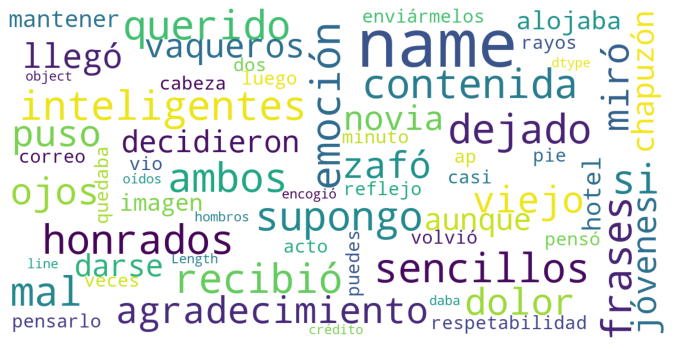



Género: cortazar


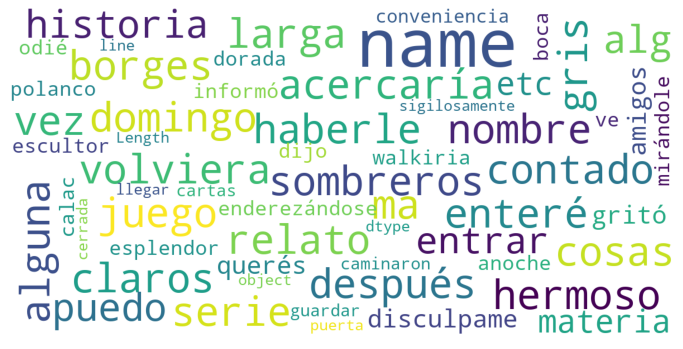



Género: poesía


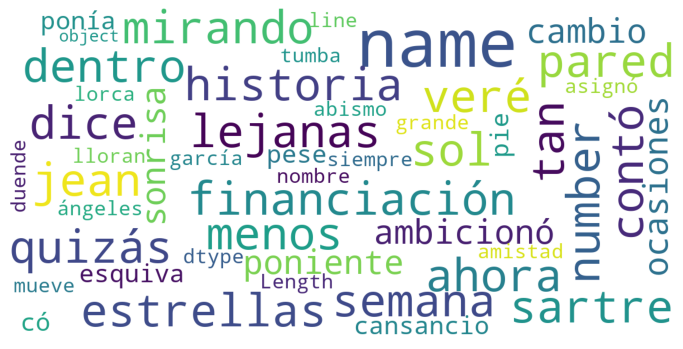



Género: filosofia


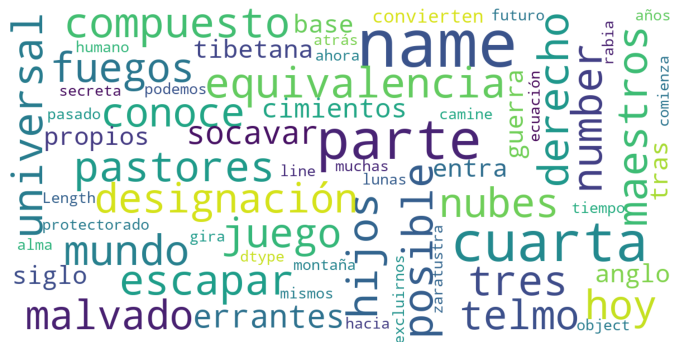

In [46]:
for genero in data_tokens.genre.value_counts().index:
  print('\n')
  print('Género:',genero)
  show_wordcloud(data_tokens[data_tokens['genre'] == genero].line)



Sentimiento: NEG


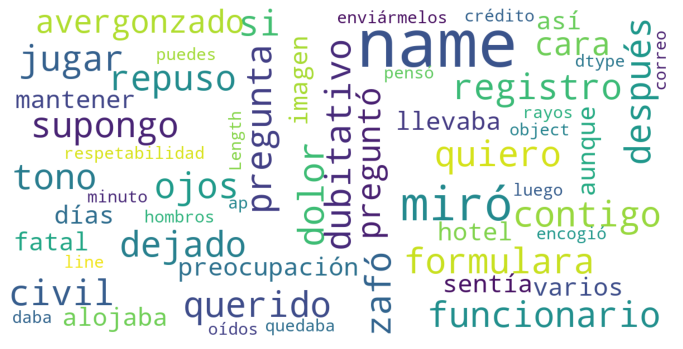



Sentimiento: NEU


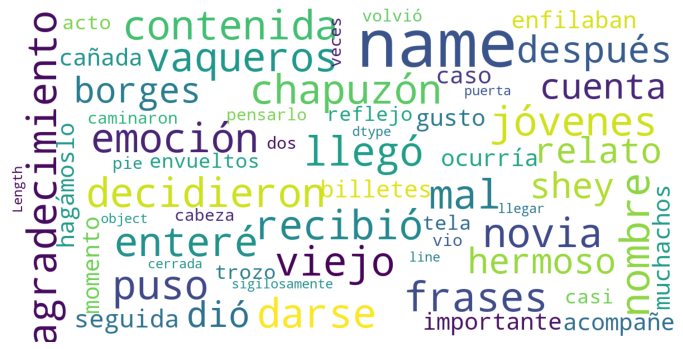



Sentimiento: POS


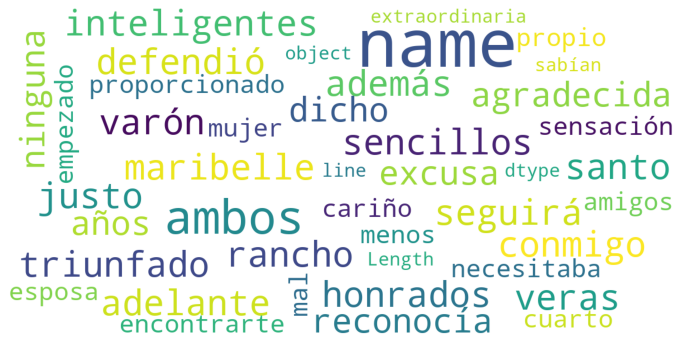

In [47]:
for sent in data_tokens.sent.value_counts().index:
  print('\n')
  print('Sentimiento:',sent)
  show_wordcloud(data_tokens[data_tokens['sent'] == sent].line)

# Analisis Visual del espacio latente

In [76]:
# Analisis Visual del espacio latente
def plot_label_clusters(vae, z_mean, labels=None, z_fixed=0):
  # display a 2D plot of the digit classes in the latent space
  ax_y = int(LATENT_SPACE / 4)
  fig, axes = plt.subplots(4, ax_y, figsize=(20,12))
  fig.subplots_adjust(hspace=0.4)
  z = 0
  colors = ['b', 'c', 'y', 'm']
  for x in range(4):
    for y in range(ax_y): 
      axes[x, y].scatter(z_mean[:, z_fixed], z_mean[:, z], c=labels)
      axes[x, y].set_xlabel("z["+ str(z_fixed) +"] | z["+ str(z) +"]") 
      # axes[x, y].ylabel("z["+ str(i) +"]")
      z += 1



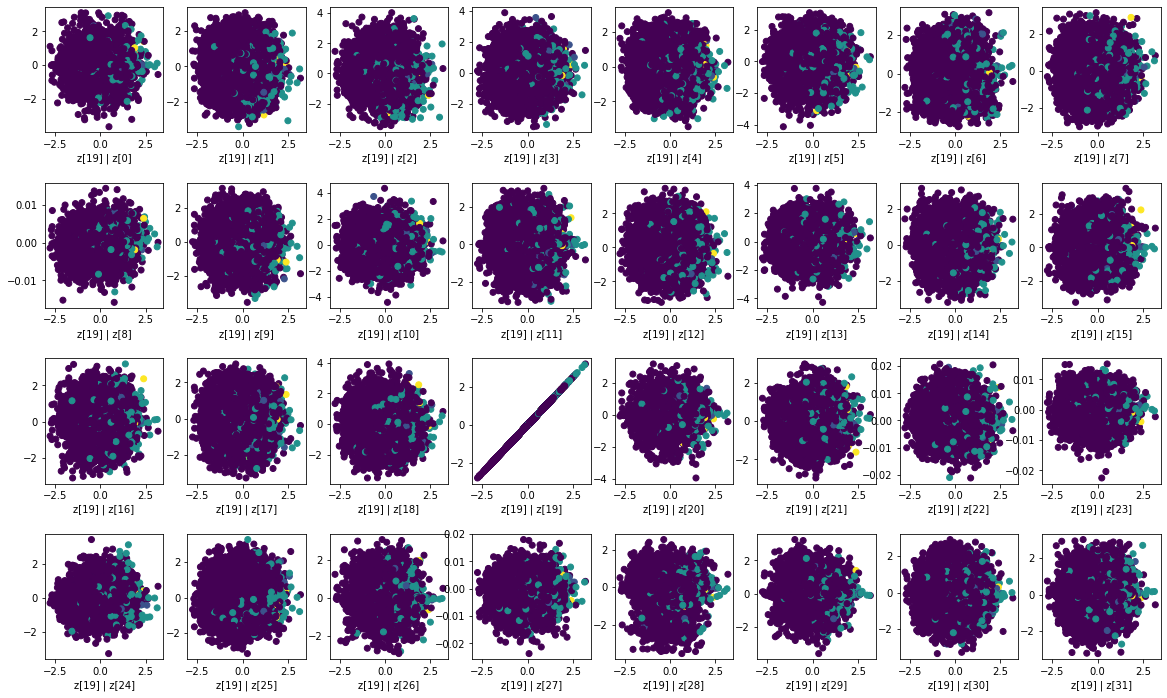

In [93]:
key_words_search_in_latent_space(data_tokens_test, ['!','¡','¿','?'])
plot_label_clusters(model, z_mean, data_tokens_test['words_search'], 19)

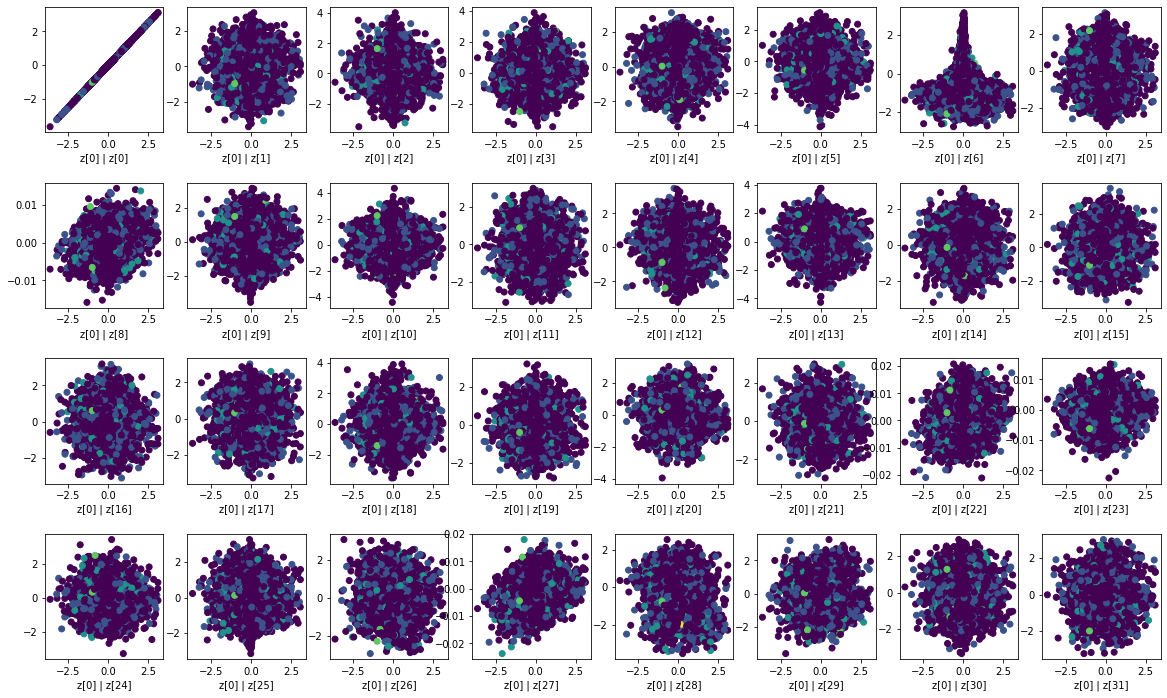

In [108]:
key_words_search_in_latent_space(data_tokens_test, ['los', 'las','aquellos','todos','todas'])
plot_label_clusters(model, z_mean, data_tokens_test['words_search'], 0)

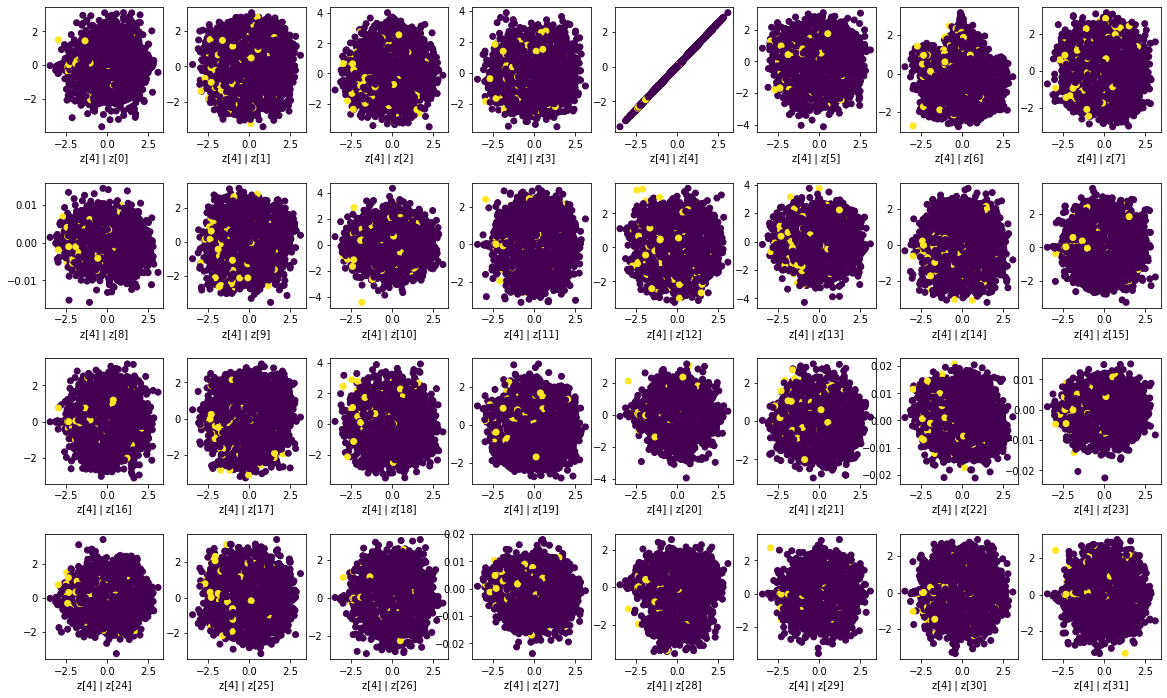

In [124]:
data_tokens_test['words_search'] = data_tokens_test['genre'].apply(lambda x: int(x == 'poesía') )
plot_label_clusters(model, z_mean, data_tokens_test['words_search'], 4)

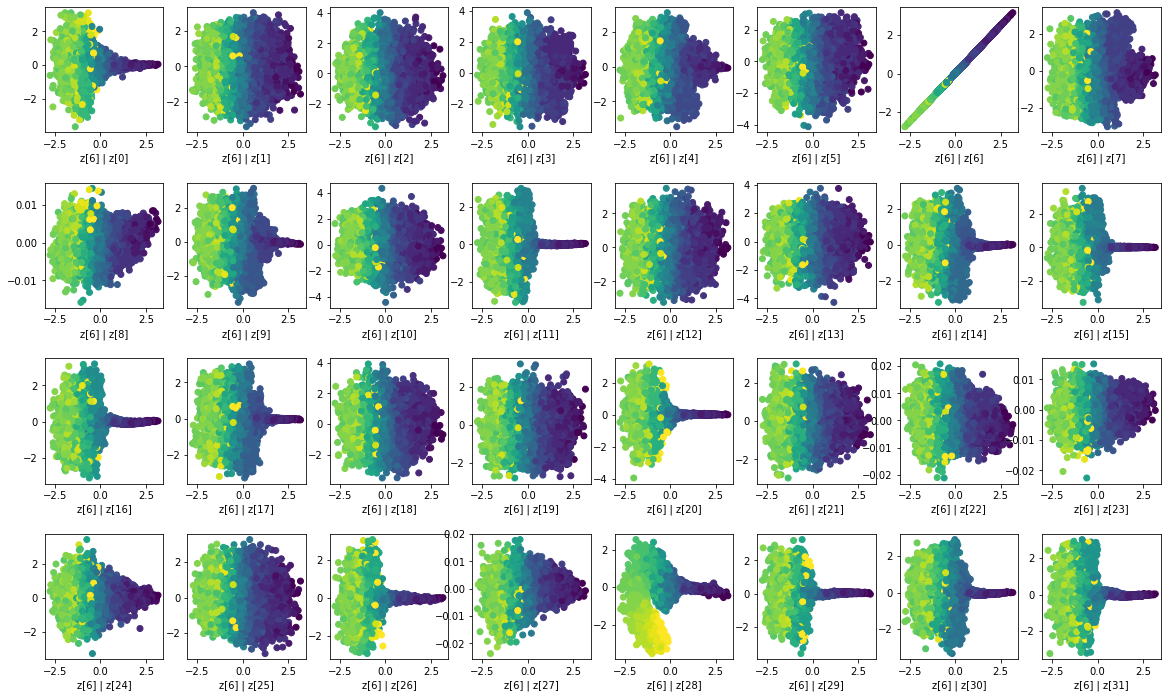

In [174]:
plot_label_clusters(model, z_mean, data_tokens_test['len'], 6)

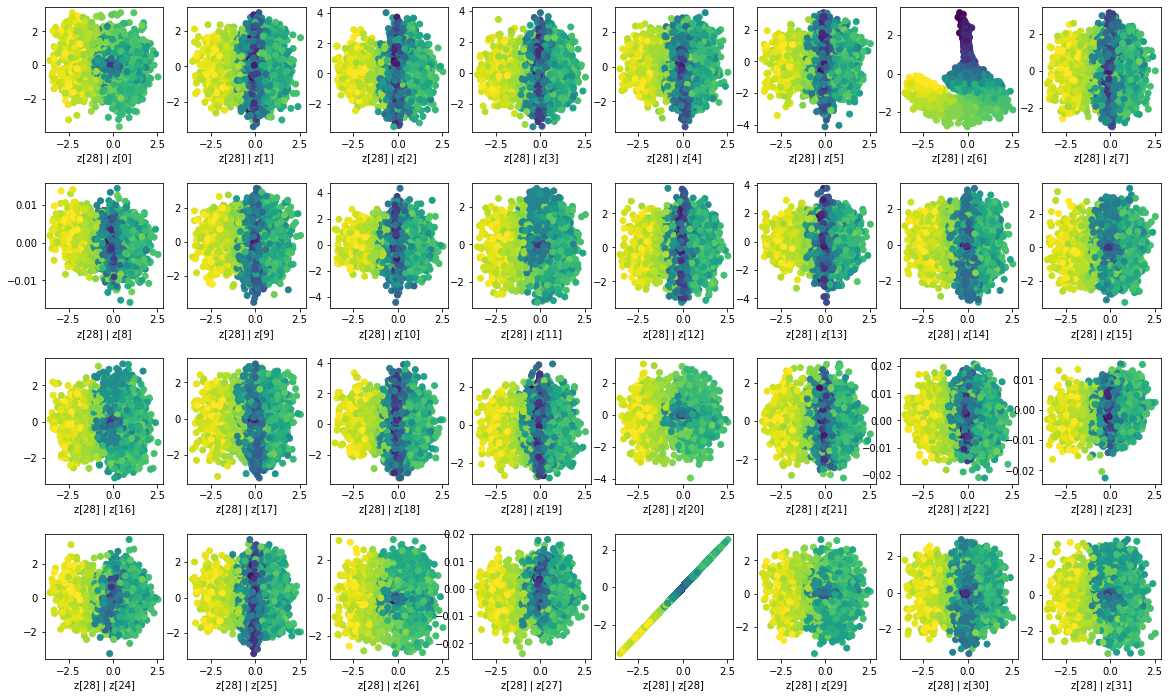

In [96]:
plot_label_clusters(model, z_mean, data_tokens_test['len'], 28)

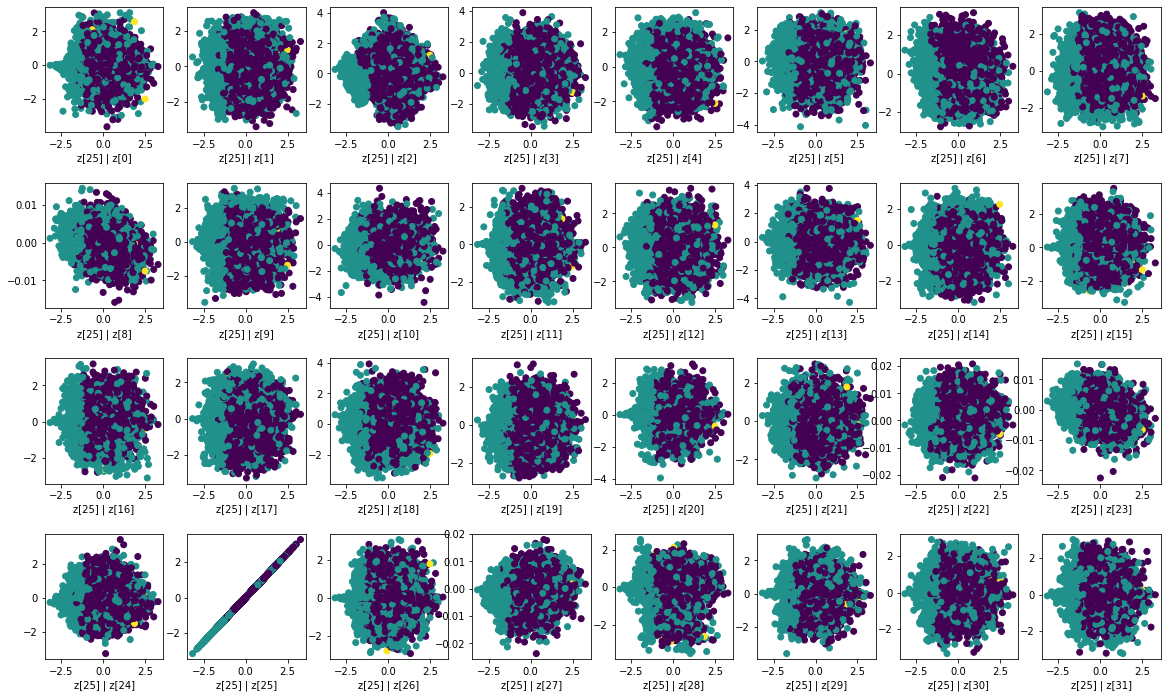

In [97]:
key_words_search_in_latent_space(data_tokens_test, ['@name'])
plot_label_clusters(model, z_mean, data_tokens_test['words_search'], 25)

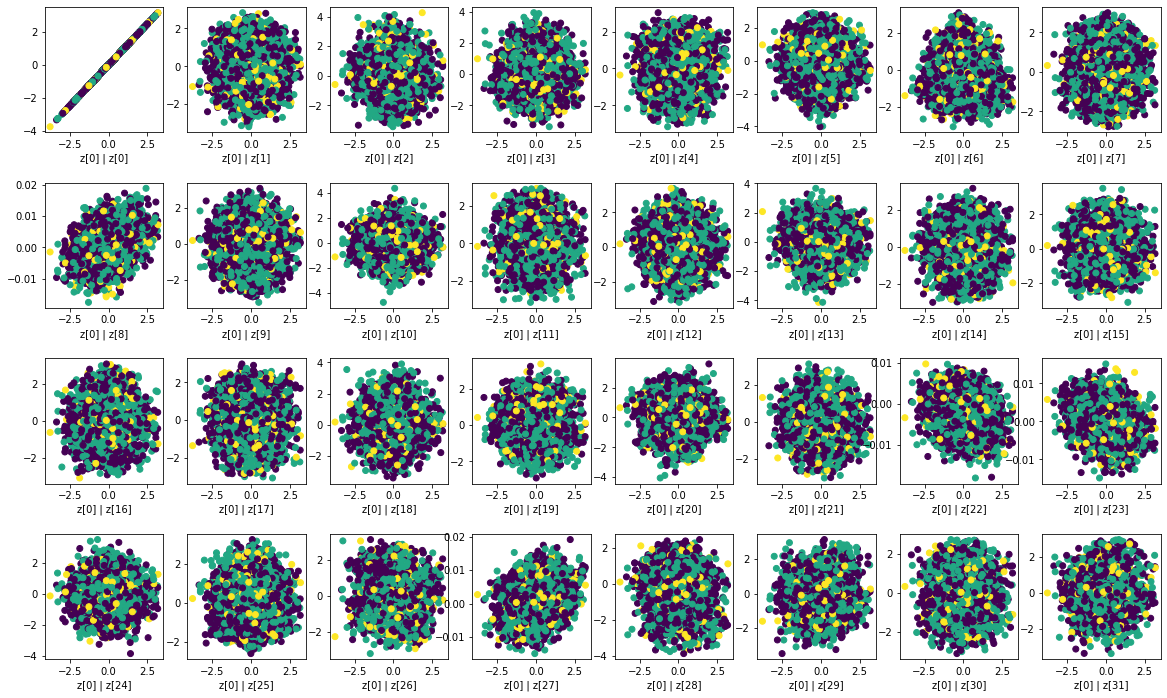

In [85]:
data_tokens_test['words_search'] = data_tokens_test['sent'].apply(lambda x: int(x.replace('NEG', '0').replace('NEU', '3').replace('POS', '5')))
plot_label_clusters(model, z_mean, data_tokens_test['words_search'], 0)